# Project 2: Deep Learning

## Part 1: Theory Questions


## Part 2: Alternative approach - Backpropagtion

Instead of using the proposed approach, that finds expressions for updating $W$ and the $K_m$ directly, we could also use the backpropagation principle, that is used in the Deep Learning community successfully.
The idea is to make use of the chain rule and computing the gradients for intermediate stages ("divide and conquer"). 
First of all we find the computational graph for our problem (see Figure).
<img src="files/compGraph.PNG">

In the graph we start from $Y_0$ and "unroll" the Euler steps, that are computed one after each other before in the end the objective function $J$ is computed.
As in the other approach we seek for the expressions $\frac{\partial J}{\partial W}$ and $\frac{\partial J}{\partial K_m}$.
To find an expression for the gradient of $J$ w.r.t. $W$, we follow the graph from $J$ to $W$ and find this as:

$$
    \frac{\partial J}{\partial W} =
    \frac{\partial J}{\partial A} \cdot
    \frac{\partial A}{\partial B} \cdot
    \frac{\partial B}{\partial D} \cdot
    \frac{\partial D}{\partial W}
$$

Note that $A, B, D \in \mathbb{R}^{N}$ 
Now we have to find the single intermediate stage derivatives.

$$
    J = \frac{1}{2} || A ||^2_2 = \frac{1}{2} A^TA
$$

$$
    \frac{\partial J}{\partial A} = A
$$

$$
    A = B-C
$$

$$
    \frac{\partial A}{\partial B} = 1
$$

$$
    B = \eta(D)
$$

$\eta$ is the in binary classification often used sigmoid function. It provides a valid probability distribution over the classes 0 and 1.
The derivative of the sigmoid function is know as:

$$
    \frac{\partial B}{\partial D} = \eta(D) \cdot (1-\eta(D))
$$

$$
    D = Y_M \cdot W
$$

$$
    \frac{\partial D}{\partial W} = Y_M
$$

Putting all together we find
$$
    \frac{\partial J}{\partial W} =
    \frac{\partial J}{\partial A} \cdot
    \frac{\partial A}{\partial B} \cdot
    \frac{\partial B}{\partial D} \cdot
    \frac{\partial D}{\partial W}
    =
    Y_M^T \left( \eta(B-C) \odot \eta(D) \odot (1-\eta(D)) \right)
$$

This is nothing else but the solution given, but in a backpropagation formulation.

The same procedure is done to find the $\frac{\partial J}{\partial Y_M}$. As we go down the same way on the computational graph as before only need a result for the last step.

$$
    D = Y_M \cdot W
$$
$$
    \frac{\partial D}{\partial Y_M} = W
$$

Putting all together we find

$$
    \frac{\partial J}{\partial Y_M} =
    \frac{\partial J}{\partial A} \cdot
    \frac{\partial A}{\partial B} \cdot
    \frac{\partial B}{\partial D} \cdot
    \frac{\partial D}{\partial Y_M}
    =
    \left( \eta(B-C) \odot \eta(D) \odot (1-\eta(D)) \right)W^T
$$

The derivative $\frac{\partial J}{\partial Y_M}$ can now be used as upstream gradient while going through the last Euler step. Finding the derivative $\frac{\partial Y_{m+1}}{\partial Y_{m}}$ we can then pass the gradient from one Euler step to the previous. The derivatives $\frac{\partial J}{\partial Y_{m}}$ and $\frac{\partial J}{\partial K_{m}}$, we are actually interested in, can be computed as

$$
    \frac{\partial J}{\partial Y_{m}} =
    \frac{\partial J}{\partial Y_{m+1}} \cdot \frac{\partial Y_{m+1}}{\partial Y_{m}}
$$

$$
    \frac{\partial J}{\partial K_{m}} =
    \frac{\partial J}{\partial Y_{m+1}} \cdot \frac{\partial Y_{m+1}}{\partial K_{m}}
$$

where $\frac{\partial J}{\partial Y_{m+1}}$ is the upstream gradient we get from the upper Euler step, that we already computed. This is what makes backpropagation so powerful here.

So within one Euler step we compute the gradient to pass further:

$$
    \frac{\partial Y_{m+1}}{\partial Y_{m}} =
    \frac{Y_{m+1}}{\partial a} \cdot
    \frac{\partial a}{\partial b} \cdot
    \frac{\partial b}{\partial c} \cdot
    \frac{\partial c}{\partial Y_{m}}
    + \frac{\partial Y_{m+1}}{\partial d}
$$

The single expressions are:

$$
    Y_{m+1} = a + d
$$

$$
    \frac{\partial Y_{m+1}}{\partial a} = 1
$$

$$
    \frac{\partial Y_{m+1}}{\partial d} = 1
$$

$$
   a = h \cdot b
$$
$$
    \frac{\partial a}{\partial b} = h
$$

$$
   b = \sigma(c) = \tanh(c)
$$

$$
    \frac{\partial b}{\partial c} = 1 - \tanh(c)^2
$$

$$
    c = Y_m \cdot K_m
$$

$$
    \frac{\partial c}{\partial Y_m} = K_m
$$

This leads to:

$$
    \frac{\partial Y_{m+1}}{\partial Y_{m}} =
    \frac{Y_{m+1}}{\partial a} \cdot
    \frac{\partial a}{\partial b} \cdot
    \frac{\partial b}{\partial c} \cdot
    \frac{\partial c}{\partial Y_{m}}
    + \frac{\partial Y_{m+1}}{\partial d}
    =
    \left(h \cdot \left( 1 - \tanh(c)^2 \right) \right) K_m^T + 1
$$

For the gradient for $K_m$ we go down the graph the same way but the last stage.

$$
    \frac{\partial c}{\partial K_m} = Y_m
$$

We find:

$$
    \frac{\partial Y_{m+1}}{\partial K_{m}} =
    \frac{Y_{m+1}}{\partial a} \cdot
    \frac{\partial a}{\partial b} \cdot
    \frac{\partial b}{\partial c} \cdot
    \frac{\partial c}{\partial K_{m}}
    =
    Y_m^T \left(h \cdot \left( 1 - \tanh(c)^2 \right) \right)
$$

## Part 3: Implementation

Our implementation is split into 2 parts. One is the brute force approach with numerical gradient computation as specified in the problem sheet. The other is the variant using analytical gradient computation and some additional features, known from Deep Learning, that will be discussed later.

In [1]:
import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
import make_circle_problem as mcp

### Euler (forward Model)
The Euler function for the forward model as specified in the problem sheet:

In [2]:
def Euler(M, h, K, Y0, sigma):
    Y = np.array(Y0)
    for i in range(M):
        Y += h * sigma(np.dot(Y, K[i]))
    return Y

To save recomputation of intermediate results in the backpropagation, we store intermediate results in this variant.

In [3]:
def EulerBackProp(M, h, K, Y0, sigma):
    Y_list = []
    sigma_list = []
    Y = np.array(Y0)
    Y_list.append(np.copy(Y))
    for i in range(M):
        sigma_value = sigma(np.dot(Y, K[i]))
        Y += h * sigma_value
        sigma_list.append(np.copy(sigma_value))
        Y_list.append(np.copy(Y))
    return Y, sigma_list, Y_list

### Objective Function

The objective function calculates an error estimate using the current K and W.

In [4]:
def ObjFunc(M, h, K, Y0, sigma, eta, C, W):
    YM = Euler(M, h, K, Y0, sigma)
    projv = eta(np.dot(YM, W))
    return (1/2)*nl.norm(projv - C)**2

### Analytical Gradient Computation

In [5]:
def etader(x):
    return np.exp(x)/(np.exp(x)+1)**2

def sigmader(x):
    return 1/np.cosh(x)**2


def Wgrad(M, h, K, Y0, sigma, eta, C, W):
    YM = Euler(M, h, K, Y0, sigma)
    y = np.dot(YM, W)
    return np.dot(YM.T, etader(y)*(eta(y) - C))


def Kgrad(M, h, K, Y0, sigma, eta, C, W):
    Y, sigma_list, Y_list = EulerBackProp(M, h, K, Y0, sigma)
    y = np.dot(Y, W)
    WT = np.reshape(W, (1,4))
    dJdY = etader(y)*(eta(y)-C)
    dJdY = np.reshape(dJdY, (np.size(dJdY), 1))
    dJdY = np.dot(dJdY, WT)
    dK = np.zeros((M,4,4))
    U = np.array(dJdY)
    for i in range(M):
        U += np.dot(h*(sigmader(np.dot(Y_list[M-(i+1)],K[M-1-i]))*U), K.T)[...,:,0]
        arg = h*(sigmader(np.dot(Y_list[M-i-1], K[M-1-i])))*U
        dK[M-i-1] = np.dot(Y_list[M-i-1].T, arg)
    return dK

### Numerical Gradient Computation

The function GradCalc computes the gradient of J numerically using the procedure given in the project description. It introduces a small pertubation to one of the Ks or W and calculates the derivative of J with respect to K or W.

In [6]:
def GradCalc(M, h, K, Y0, sigma, eta, C, W, eps):
    dJ = np.zeros((M, 4, 4))
    j1 = ObjFunc(M, h, K, Y0, sigma, eta, C, W)
    for m in range(M):
        for i in range(4):
            for j in range(4):
                temp = np.zeros((4,4))
                temp[i,j] = eps
                dK = np.array(K)
                dK[m] += temp
                j2 = ObjFunc(M, h, dK, Y0, sigma, eta, C, W)
                dJ[m,i,j] = (j2-j1)/eps

    dW = np.zeros(4)
    w1 = ObjFunc(M, h, K, Y0, sigma, eta, C, W)
    for i in range(4):
        temp = np.zeros(4)
        temp[i] = eps
        Wp = np.array(W) + temp
        w2 = ObjFunc(M, h, K, Y0, sigma, eta, C, Wp)
        dW[i] = (w2-w1)/eps
    return dJ, dW

### Backpropagation variant

For the backpropagation variant, we put forward and backward model in one class, to use intermediate results of the forward computation in the backward computation.
One can see the implementation of formulas derived before.

In [7]:
def ObjFuncAndBackProp(M, h, K, Y0, sigma, eta, C, W):
    #Forward model
    YM, sigma_list, Y_list = EulerBackProp(M, h, K, Y0, sigma)
    projv = eta(np.dot(YM, W))
    error = (1/2)*nl.norm(projv - C)**2

    #Backpropagation
    #deriv. w.r.t. W
    dW = np.dot(YM.T, ((projv - C) * projv * (1 - projv)))    # * is elementwise (hadamard) operation

    #deriv. w.r.t. YM
    dYM = np.array(np.matrix((projv - C) * projv * (1 - projv)).T * np.matrix(W.T))  # * is elementwise (hadamard) operation

    #deriv. w.r.t. the different K_m
    #Starting with dYM as first upstream derivative we pass the gradient through the computational graph
    dJ = np.zeros((M, 4, 4))
    dY_upstream = dYM
    for i in range(len(Y_list)-2, -1, -1):
        dJ[i] = Y_list[i].T.dot(h * (1 - sigma_list[i] ** 2) * dY_upstream)
        dY_upstream = np.dot((h * (1 - sigma_list[i] ** 2) * dY_upstream), K[i].T) + dY_upstream
    return error, dJ, dW

### Parameter update

For the parameter update we have to different options. First is the proposed standard gradient descent (GD) update.

In [8]:
def SGD_update(x, dx, tau):
    return x - tau * dx

Second option is the ADAM method. This method is currently the most used update method in the Deep Learning community, due to its beneficial effects.
While the GD uses just the gradient itself for updating the parameters, ADAM introduces a so called "momentum". The meaning of this can be explained in a phyical analogy of a ball with friction.
While the ball rolls in one direction for a longer time, it builds up velocity. Even if there are small valleys in the topology, due to the velocity it can (probably) roll out of those again and eventually roll to the lowest point.
In the context of nonlinear optimization this means we (probably) can avoid getting stuck in local minima as we seek for the global minimum and as well get faster to the minimum as we use the momentum.
The deviation and updates formulas can be found in the original paper (https://arxiv.org/abs/1412.6980).

In [9]:
def adam_update(value, g_t, t, m_t_old, v_t_old):
    t += 1
    m_t = beta_1 * m_t_old + (1 - beta_1) * g_t  # updates the moving averages of the gradient
    v_t = beta_2 * v_t_old + (1 - beta_2) * (g_t * g_t)  # updates the moving averages of the squared gradient
    m_cap = m_t / (1 - (beta_1 ** t))  # calculates the bias-corrected estimates
    v_cap = v_t / (1 - (beta_2 ** t))  # calculates the bias-corrected estimates
    value -= np.divide((alpha * m_cap), (np.sqrt(v_cap) + epsilon))
    return value

### Training

Our training method computes forward and backward model and updates the parameters. The user can choose which variant to use.

In [10]:
def Train(M, h, K, Y0, sigma, eta, C, W, eps, TOL, tau, gradient_variant=1, update_variant=1, max_step=200000):
    res = np.inf
    res_list = []
    count = 0
    
    #Parameter Adam
    m_t_K = 0
    v_t_K = 0
    m_t_W = 0
    v_t_W = 0
    
    while res > TOL and count < max_step:
        #numerical
        if gradient_variant == 0:
            res = ObjFunc(M, h, K, Y0, sigma, eta, C, W)
            dJ, dW = GradCalc(M, h, K, Y0, sigma, eta, C, W, eps)
        #analytically - backpropagation
        if gradient_variant == 1:
            res, dJ, dW = ObjFuncAndBackProp(M, h, K, Y0, sigma, eta, C, W)
        
        #analytically
        if gradient_variant == 2:
            res = ObjFunc(M, h, K, Y0, sigma, eta, C, W)
            dW = Wgrad(M, h, K, Y0, sigma, eta, C, W)
            dJ = Kgrad(M, h, K, Y0, sigma, eta, C, W)
        
        #Updates
        #Stochastic gradient descent (as proposed in the problem sheet)
        if update_variant == 0:
            K = SGD_update(K, dJ, tau)
            W = SGD_update(W, dW, tau)

        #Adam updates
        if update_variant == 1:
            W = adam_update(W, dW, count, m_t_W, v_t_W)
            K = adam_update(K, dJ, count, m_t_K, v_t_K)

        if count % 1000 == 0:
            print("Residual at step " + str(count) + ": " + str(res))
        res_list.append(res)
        count += 1
    return K, W, res_list

### Auxiliary functions



The functions eta and sigma are implemented as given in the project description. The function res_plot plots the residual versus steps, and get_accuracy checks how well the model predicts the color of the points.

In [11]:
def eta(x):
    return np.exp(x)/(np.exp(x) + 1)

def sigma(x):
    return np.tanh(x)

def res_plot(res_list):
    plt.plot(list(range(len(res_list))), res_list)
    plt.xlabel("epoch")
    plt.ylabel("residual")
    plt.title("Residual plot")
    plt.show()

def get_accuracy(YM, W):
    projv = eta(np.dot(YM, W))
    guess = np.around(projv)
    diff = guess - C
    wrong_guesses = np.count_nonzero(diff)
    accuracy = (1 - wrong_guesses / n)
    return accuracy

### Main function

Here the parameters are initialized, the model trained and tested.

Residual at step 0: 62.03597275478005
Residual at step 1000: 43.07198860446589
Residual at step 2000: 40.7483942383711
Residual at step 3000: 40.16508825611385
Residual at step 4000: 39.49742512223075
Residual at step 5000: 38.444267568779836
Residual at step 6000: 36.88741631826842
Residual at step 7000: 34.92970090920563
Residual at step 8000: 29.138064278215246
Residual at step 9000: 17.02049075688462
Residual at step 10000: 9.28011202653552
Residual at step 11000: 5.698720944304166


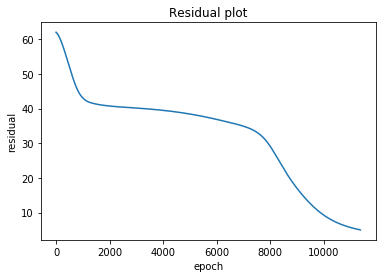

Accuracy on training set: 98.2%
Accuracy on test set: 51.800000000000004%


In [12]:
#Number of points
n = 500
#Precision of points
nx = 200
#number of Euler steps
M = 20
eps = 0.005
#Learning rate of GD
tau = 0.1

h = 0.1
#tolerance depending on n
TOL = 0.01 * n



#Parameter ADAM
alpha = 0.00005 #learning rate ADAM
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8

#self-made function, to get data into useful shape
Y0, C = mcp.YC(n, nx, False)
K = np.full((M,4,4), np.identity(4), dtype=float)
W = np.ones(4)
for i in range(n):
    Y0[i,2] = Y0[i,0]**2
    Y0[i,3] = Y0[i,1]**2
#arguments
Eargs = (M, h, K, Y0, sigma)
OFargs = (M, h, K, Y0, sigma, eta, C, W)
GCargs = (M, h, K, Y0, sigma, eta, C, W, eps)
Targs = (M, h, K, Y0, sigma, eta, C, W, eps, TOL, tau)

#Training
K, W, res_list = Train(*Targs)
res_plot(res_list)

#Accuracy check
#Training data accuracy
YM = Euler(M, h, K, Y0, sigma)
accu = get_accuracy(YM, W)
print("Accuracy on training set: " + str(accu * 100) + "%")

#Test data accuracy
Y0, C = mcp.YC(n, nx, False)
YM = Euler(M, h, K, Y0, sigma)
accu = get_accuracy(YM, W)
print("Accuracy on test set: " + str(accu * 100) + "%")

### Validation and Comments

a) As this process is a stochastic process, depending on which points are generated, it is not sure, that the the algorithm converges nicely to 100% training accuracy. Sometimes the model gets stuck in local minima. In this case you have to start the programm again.

b) We see much faster gradient computation with the analytical version.

c) We see much faster convergence with ADAM than with GD.

d) If the model converges and we used few data points we see very good classification results for the training data (90-100%), but not for the test data. This is due to "overfitting". The model learns the few data points by hard and has poor generalization characteristics. To overcome this one would need to introduce regularization or use more data.

e) As we one apply transformations from $\mathbb{R}^4$ to $\mathbb{R}^4$, we operate in the 4-dimensional-space only and therefore have not much "capacity" in the model.


